## Inter-annotator agreement in CoNLL-2014 Test Data

In [1]:
from lxml import html
import pandas as pd
import numpy as np
import re
from collections import OrderedDict

sgml files of CoNLL-2014 Test Data provide structured, easy-to-parse data. We begin with extracting data for each correction and putting it into a pandas DataFrame for further analysis.

In [2]:
def extract_docs(filename):
    with open(filename) as f:
        anns = f.read()
    # method fromstring() provides a list of elements and allows xml parsing without a single root
    docs = html.fromstring(anns).xpath('doc')
    return docs

In [3]:
def parse_corrections(filename):
    """
    A function to parse corrections from sgml file and
    turn them into a pandas DataFrame (for further processing)
    """
    docs = extract_docs(filename)
    df = pd.DataFrame()
    for doc in docs:
        doc_id = doc.xpath('@nid')
        teacher_id = doc.xpath('annotation/@teacher_id')[0]
        for mistake in doc.xpath('annotation/mistake'):
            row_dic = OrderedDict()
            row_dic['doc_id'] = doc_id
            row_dic['teacher_id'] = teacher_id
            row_dic['start_par'] = mistake.xpath('@start_par')[0]
            row_dic['start_off'] = mistake.xpath('@start_off')[0]
            row_dic['end_par'] = mistake.xpath('@end_par')[0]
            row_dic['end_off'] = mistake.xpath('@end_off')[0]
            row_dic['type'] = mistake.xpath('type/text()')[0]
            if len(mistake.xpath('correction/text()')) == 0:
                row_dic['correction'] = ''
            else:
                row_dic['correction'] = mistake.xpath('correction/text()')[0]
            row_df = pd.DataFrame(row_dic)
            df = pd.concat([df, row_df])
    return df

Let's create two pandas DataFrames with corrections for each teacher

In [4]:
corr_0 = parse_corrections('conll14st-test-data/noalt/official-2014.0.sgml')
corr_1 = parse_corrections('conll14st-test-data/noalt/official-2014.1.sgml')

# make sure that data types are numeric where possible
corr_0 = corr_0.apply(pd.to_numeric, errors='ignore')
corr_1 = corr_1.apply(pd.to_numeric, errors='ignore')

How does our DataFrame look like?

In [5]:
corr_0.head()

,doc_id,teacher_id,start_par,start_off,end_par,end_off,type,correction
0,1,8,1,42,1,46,ArtOrDet,
0,1,8,1,118,1,125,Nn,diseases
0,1,8,1,620,1,627,Trans,"However,"
0,1,8,1,740,1,751,Mec,diagnosed
0,1,8,1,751,1,754,Prep,


How many corrections each of the teachers has made?

In [6]:
n_0 = len(corr_0)
n_1 = len(corr_1)
print('Teacher 8 has made {n_0} corrections, while teacher 9 has made {n_1}'
      .format(n_0=n_0, n_1=n_1))

Teacher 8 has made 2397 corrections, while teacher 9 has made 3331


Difference is pretty big! Why so?

We can check how long is typical mistake and typical correction for each of the teachers.

In [7]:
corr_0['len_mistake'] = corr_0['end_off'] - corr_0['start_off']
corr_1['len_mistake'] = corr_1['end_off'] - corr_1['start_off']

corr_0['len_corr'] = corr_0['correction'].apply(len)
corr_1['len_corr'] = corr_1['correction'].apply(len)

In [8]:
print('For first teacher, mean values are:\n', corr_0[['len_mistake', 'len_corr']].mean(), sep='')
print('For second teacher:\n', corr_1[['len_mistake', 'len_corr']].mean(), sep='')

For first teacher, mean values are:
len_mistake    6.513141
len_corr       6.125156
dtype: float64
For second teacher:
len_mistake    6.646653
len_corr       6.388172
dtype: float64


From this data it looks like second teacher was more thorough: (s)he noticed mistakes more often, covered a bit more characters in each mistake and proposed correspondingly longer corrections. By contrast, first teacher was more laconic.

***
Let's analyze inter-annotator agreement on several dimensions - type of mistake, span of mistake (for now we overlook misaligned spans), and the content of correction (what is substituted). 

In [9]:
# full agreement on type, span and content of correction
agr1 = len(corr_0.merge(corr_1[['doc_id', 'start_par', 'start_off', 'end_par', 'end_off',
       'type', 'correction']], how='inner'))
print('In {n} cases both teachers agreed on type, span and content of correction, \
which is {p1:.2%} of all for first teacher and {p2:.2%} for second'
      .format(n=agr1, p1=agr1/n_0, p2=agr1/n_1))

In 662 cases both teachers agreed on type, span and content of correction, which is 27.62% of all for first teacher and 19.87% for second


In [10]:
# agreement on type and span
agr2 = len(corr_0.merge(corr_1[['doc_id', 'start_par', 'start_off', 'end_par', 'end_off',
       'type']], how='inner'))
print('In {n} cases both teachers agreed on type and span of correction, \
which is {p1:.2%} of all for first teacher and {p2:.2%} for second'
      .format(n=agr2, p1=agr2/n_0, p2=agr2/n_1))

In 813 cases both teachers agreed on type and span of correction, which is 33.92% of all for first teacher and 24.41% for second


In [11]:
# agreement on span and correction
agr3 = len(corr_0.merge(corr_1[['doc_id', 'start_par', 'start_off', 'end_par', 'end_off',
       'correction']], how='inner'))
print('In {n} cases both teachers agreed on span and content of correction, \
which is {p1:.2%} of all for first teacher and {p2:.2%} for second'
      .format(n=agr3, p1=agr3/n_0, p2=agr3/n_1))

In 822 cases both teachers agreed on span and content of correction, which is 34.29% of all for first teacher and 24.68% for second


In [12]:
# agreement on span only
agr4 = len(corr_0.merge(corr_1[['doc_id', 'start_par', 'start_off', 'end_par', 'end_off']], 
                 how='inner'))
print('In {n} cases both teachers agreed that in a specific span there is a mistake, \
which is {p1:.2%} of all for first teacher and {p2:.2%} for second'
      .format(n=agr4, p1=agr4/n_0, p2=agr4/n_1))

In 1162 cases both teachers agreed that in a specific span there is a mistake, which is 48.48% of all for first teacher and 34.88% for second


***
What is the distribution of types of mistakes in work of each teacher?

In [13]:
type_counts = (pd.concat([corr_0['type'].value_counts().rename('teacher_0'), 
            corr_1['type'].value_counts().rename('teacher_1')], axis=1)
            .sort_values(by='teacher_1', ascending=False))
type_counts.head(10)

,teacher_0,teacher_1
Mec,231.0,496
Wci,340.0,479
ArtOrDet,332.0,444
Prep,211.0,390
Nn,215.0,228
Rloc-,95.0,199
SVA,105.0,154
Pref,96.0,153
Vt,133.0,150
Wform,77.0,103


Data like this is better viewed in a graph. Let's make a crude barplot of types of corrections in Seaborn.

In [14]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 8)})
sns.set_style('whitegrid')

In [15]:
# reshape data for seaborn
types_df = (type_counts.reset_index()
 .rename(columns={'teacher_0': 'First', 'teacher_1': 'Second', 'index': 'Type'})
 .melt(id_vars=['Type'], value_name='Type Count', var_name='Teacher'))

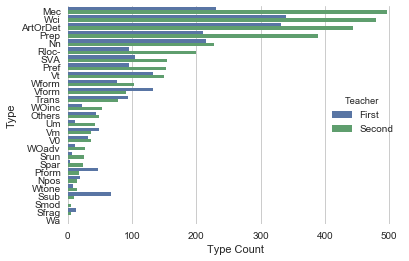

In [16]:
sns.barplot(x='Type Count', y='Type', hue='Teacher', data=types_df)
sns.despine(bottom=True, left=True)

***
It is not easy to align corrections of two teachers, since one corrected more than the other, but we can iterate over mistake spans and look for places corrected by both or only one teacher

Let's start with combining dfs for each teacher and sorting by the order of mistakes in documents: start with the first mistake in first paragraph in first document, and go on.

In [17]:
comb_corr = (corr_0.append(corr_1)
 .sort_values(by=['doc_id', 'start_par', 'start_off', 'teacher_id'])
 .reset_index())
comb_corr.head()

,index,doc_id,teacher_id,start_par,start_off,end_par,end_off,type,correction,len_mistake,len_corr
0,0,1,8,1,42,1,46,ArtOrDet,,4,0
1,0,1,9,1,42,1,46,Rloc-,,4,0
2,0,1,8,1,118,1,125,Nn,diseases,7,8
3,0,1,9,1,118,1,125,Nn,diseases,7,8
4,0,1,9,1,597,1,604,Vt,will develop,7,12


In [18]:
# there are no cases when mistake is carried to the next paragraph, so we don't worry about end_par
if len(comb_corr[comb_corr['start_par'] != comb_corr['end_par']]) > 0: print('!!!')

We write a simple program to check for each pair of correction spans if they are overlapping fully, partially or not at all. To make sure that we don't double count, we use flag *previous*. We also collect partial overlaps in a separate array.

In [19]:
full = 0
partial = 0
partial_list = []
not_intersect = 0

previous = True
for i, j in zip(comb_corr.index, comb_corr.index[1:]):
    if previous:
        previous = False
        continue
    if ((comb_corr.iloc[i]['doc_id'] == comb_corr.iloc[j]['doc_id']) and 
        (comb_corr.iloc[i]['start_par'] == comb_corr.iloc[j]['start_par']) and
        (comb_corr.iloc[i]['teacher_id'] != comb_corr.iloc[j]['teacher_id'])):
        istart, iend = comb_corr.iloc[i]['start_off'], comb_corr.iloc[i]['end_off']+1
        jstart, jend = comb_corr.iloc[j]['start_off'], comb_corr.iloc[j]['end_off']+1
        iarr = np.array(range(istart, iend))
        jarr = np.array(range(jstart, jend))
        intersect = np.intersect1d(iarr, jarr)
        if len(intersect) == 0:
            not_intersect += 1
        elif len(intersect) == max(len(iarr), len(jarr)):
            full += 1
            previous = True
        elif len(intersect) < max(len(iarr), len(jarr)):
            partial += 1
            part_overlap = (comb_corr.iloc[i]['doc_id'], comb_corr.iloc[i]['start_par'], iarr, jarr)
            partial_list.append(part_overlap)
            previous = True

In [20]:
print('There are {f} full overlaps, {p} partial ones,\
 and {n} cases where neighboring mistake spans of two teachers are not overlapping'
     .format(f=full, p=partial, n=not_intersect))

There are 1144 full overlaps, 390 partial ones, and 1079 cases where neighboring mistake spans of two teachers are not overlapping


How big are differences between overlapping spans of different teachers? Well, they can be pretty big.

In [21]:
diffs = [abs(len(array1)-len(array2)) for d, p, array1, array2 in partial_list]
print('Maximal difference is {mx}, median is {md}, and average is {mn:.2f}'
      .format(mx=max(diffs), md=np.median(diffs), mn=np.mean(diffs)))

Maximal difference is 90, median is 7.0, and average is 10.53


***
One more way to look at the inter-annotator agreement - just apply their corrections to each paragraph and compare similarity between corrected paragraphs (i.e., minimum edit distance). 

In [22]:
def correct_paragraph(paragraph, span_list):
    """
    This function uses cursor to reconstruct corrected paragraphs 
    by adding slices of original paragraph one by one and only making
    corrections where span_list (consisting of indices and correction itself)
    indicates.
    """
    res_par = ''
    cursor = 0
    for start, end, correction in span_list:
        res_par += paragraph[cursor:start] + correction
        cursor = end
    res_par += paragraph[cursor:]
    res_par = re.sub(r' +', ' ', res_par)
    return res_par

In [23]:
def provide_corrections(docs, doc_num, par_num):
    """
    Given list of doc elements, correct specific paragraph
    in a specific doc
    """
    p_text = get_paragraph_text(docs[doc_num], par_num)
    mistakes = (docs[doc_num].xpath('annotation')[0]
                .xpath('mistake[@start_par="{par_num}"]'.format(par_num=par_num)))
    starts = [int(m.xpath('@start_off')[0]) for m in mistakes]
    ends = [int(m.xpath('@end_off')[0]) for m in mistakes]
    corrs = [m.xpath('correction/text()')[0] 
             if not (m.xpath('correction/text()') == []) else ''
            for m in mistakes]
    span_list = zip(starts, ends, corrs)
    return correct_paragraph(p_text, span_list)

In [24]:
def get_paragraph_text(doc, par_num):
    # one more helper function
    return doc.xpath('text/p/text()')[par_num].replace('\n', '')

Since paragraphs are identical for both sgml files, we iterate only over texts from the first one, but take corrections from both, correct paragraphs, and count edit distances for each paragraph. Since our file is not big, we also add uncorrected and corrected texts to our dictionary containing distances - to be able to have a look with our own eyes.

In [25]:
from nltk.metrics.distance import edit_distance

docs_0 = extract_docs('conll14st-test-data/noalt/official-2014.0.sgml')
docs_1 = extract_docs('conll14st-test-data/noalt/official-2014.1.sgml')

distances = OrderedDict()
for doc_num, doc in enumerate(docs_0):
    for par_num in range(len(doc.xpath('text/p'))):
        p_text = get_paragraph_text(doc, par_num)
        par_by0 = provide_corrections(docs_0, doc_num, par_num)
        par_by1 = provide_corrections(docs_1, doc_num, par_num)
        dist = edit_distance(par_by0, par_by1)
        distances[f'{doc_num}_{par_num}'] = [dist, p_text, par_by0, par_by1]

In [26]:
mean_distance = np.mean([distances[d][0] for d in distances.keys()])
mean_par_length = np.mean([len(distances[d][1]) for d in distances.keys()])
print('Average distance between paragraphs correctedby two teachers is {m:.2f},\nwith {l:.2f} \
character on average in a paragraph.'.format(m=mean_distance, l=mean_par_length))

Average distance between paragraphs correctedby two teachers is 68.23,
with 646.19 character on average in a paragraph.


We can look at a random paragraph to see the differences. Like, here we have one teacher who corrected 'are' for 'have been' in the first sentence, and one who didn't; one corrected 'they should be responsible to tell their relatives', and other didn't. Here we see how second teacher is more thorough.

In [27]:
distances['23_1']

[60,
 'More and more illness are discovered to be related to some genes with the development of the medical technology. People will know about whether they carry a disease on their genes after they have done the genetic test. If there is no problem, that will be wonderful. However, not everybody is so lucky that they can make sure they do not carry any disease genes. Therefore, once people find they have carried the disease genes, they should be responsible to tell their relatives, at least their family members.',
 'More and more illnesses are discovered to be related to genes with the development of the medical technology. People will know about whether they carry a disease in their genes after they have done the genetic test. If there is no problem, that will be wonderful. However, not everybody is so lucky that they can make sure they do not carry any diseased genes. Therefore, once people find they carry the diseased genes, they should be responsible to tell their relatives, at lea